In [1]:
import pandas as pd
from preprocess import Audio_Processor
import data_utils as du
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 44100
blocksize = 88200
overlap = 22050

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
audio_dir = '../ESC-50/audio/'

In [5]:
path_to_db='../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50

In [7]:
h_classes = ['Human & Animal', 'Interacting Materials']
mapping = {'dog': 0,'rooster': 0,'pig': 0,'cow': 0,'frog': 0,'cat': 0,'hen': 0,
            'insects': 0,'sheep': 0,'crow': 0,'rain': 1,'sea_waves': 1,'crackling_fire': 1,
            'crickets': 0,'chirping_birds': 0,'water_drops': 1,'wind': 1,'pouring_water': 1,
            'toilet_flush': 1,'thunderstorm': 1,'crying_baby': 0,'sneezing': 0,'clapping': 0,
            'breathing': 0,'coughing': 0,'footsteps': 1,'laughing': 0,'brushing_teeth': 1,
            'snoring': 0,'drinking_sipping': 1,'door_wood_knock': 1,'mouse_click': 1,
            'keyboard_typing': 1,'door_wood_creaks': 1,'can_opening': 1,'washing_machine': 1,
            'vacuum_cleaner': 1,'clock_alarm': 1,'clock_tick': 1,'glass_breaking':1,'helicopter': 1,
            'chainsaw': 1,'siren': 1,'car_horn': 1,'engine': 1,'train': 1,'church_bells': 1,
            'airplane': 1,'fireworks': 1,'hand_saw': 1,
            }

In [8]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_category'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [10]:
df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        fld=1, 
                        blocksize=blocksize, 
                        overlap=overlap)

In [11]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,106,107,108,109,110,111,112,113,l_target,h_target
count,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,...,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000
mean,46.399255,47.481091,33.223811,29.509507,27.443117,26.244452,23.810670,23.809013,22.558772,22.094493,...,-0.010395,0.011152,-0.010438,0.007996,-0.007660,0.006362,-0.006018,0.003365,0.625222,24.504440
std,25.505648,27.862436,15.859885,13.373549,12.124446,11.438281,10.071876,10.328908,9.705747,9.681488,...,0.031721,0.028980,0.027594,0.026553,0.026074,0.025936,0.023690,0.022442,0.484281,14.487864
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.157675,-0.106583,-0.125704,-0.075512,-0.110739,-0.109556,-0.108841,-0.086237,0.000000,0.000000
25%,27.178284,25.795751,21.857434,19.354777,19.300802,18.732965,16.995968,16.954051,16.210191,15.282154,...,-0.024681,-0.005575,-0.024791,-0.005670,-0.021191,-0.007326,-0.019023,-0.009467,0.000000,12.000000
50%,42.537642,44.042091,33.627569,29.919353,27.838444,26.491824,24.006821,24.214844,22.861795,22.496799,...,-0.004506,0.005206,-0.005752,0.004833,-0.003598,0.004021,-0.002838,0.000666,1.000000,25.000000
75%,65.394316,64.837833,43.205715,39.400712,35.563508,33.969391,31.051972,30.809504,28.784276,28.695025,...,0.006832,0.025501,0.006079,0.020366,0.006075,0.020025,0.006931,0.016730,1.000000,37.000000
max,134.123703,137.514175,112.408134,76.668762,74.285004,66.499321,60.113098,68.008316,54.163288,60.835384,...,0.116896,0.149008,0.074334,0.124392,0.090059,0.112636,0.111708,0.115039,1.000000,49.000000


In [12]:
from sklearn.model_selection import train_test_split
train, test, = train_test_split(
                        df, test_size=0.20, random_state=42)

In [13]:
train_X = train.drop(['l_target', 'h_target'], axis=1)
train_y = train['l_target']
test_X = test.drop(['l_target', 'h_target'], axis=1)
test_y = test['l_target']

# Shallow Net
Separate into classes

In [14]:
from keras.layers import Dense, Dropout
from keras.models import Sequential

def gpu_mfcc_deep_net_a():
    # Create Model
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(114,)))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    model.summary()

    
    return model

In [15]:
anim = KerasClassifier(build_fn=gpu_mfcc_deep_net_a, 
                       epochs=200, 
                       batch_size=128, 
                       validation_split=0.15)
history = anim.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               14720     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 19,937
Trainable params: 19,937
Non-trainable params: 0
_________________________________________________________________
Train on 765 samples, validate on 135 samples
Epoch 1/200
765/765 [==============================] - 1s 832us/step - loss: 5.6059 - acc: 0

765/765 [==============================] - 0s 32us/step - loss: 5.6059 - acc: 0.6484 - val_loss: 6.9674 - val_acc: 0.5630
Epoch 55/200
765/765 [==============================] - 0s 33us/step - loss: 5.6059 - acc: 0.6484 - val_loss: 6.9674 - val_acc: 0.5630
Epoch 56/200
765/765 [==============================] - 0s 33us/step - loss: 5.6059 - acc: 0.6484 - val_loss: 6.9674 - val_acc: 0.5630
Epoch 57/200
765/765 [==============================] - 0s 32us/step - loss: 5.6059 - acc: 0.6484 - val_loss: 6.9674 - val_acc: 0.5630
Epoch 58/200
765/765 [==============================] - 0s 31us/step - loss: 5.6059 - acc: 0.6484 - val_loss: 6.9674 - val_acc: 0.5630
Epoch 59/200
765/765 [==============================] - 0s 31us/step - loss: 5.6059 - acc: 0.6484 - val_loss: 6.9674 - val_acc: 0.5630
Epoch 60/200
765/765 [==============================] - 0s 29us/step - loss: 5.6059 - acc: 0.6484 - val_loss: 6.9674 - val_acc: 0.5630
Epoch 61/200
765/765 [==============================] - 0s 33us/step

765/765 [==============================] - 0s 28us/step - loss: 5.6059 - acc: 0.6484 - val_loss: 6.9674 - val_acc: 0.5630
Epoch 115/200
765/765 [==============================] - 0s 29us/step - loss: 5.6059 - acc: 0.6484 - val_loss: 6.9674 - val_acc: 0.5630
Epoch 116/200
765/765 [==============================] - 0s 30us/step - loss: 5.6059 - acc: 0.6484 - val_loss: 6.9674 - val_acc: 0.5630
Epoch 117/200
765/765 [==============================] - 0s 26us/step - loss: 5.6059 - acc: 0.6484 - val_loss: 6.9674 - val_acc: 0.5630
Epoch 118/200
765/765 [==============================] - 0s 24us/step - loss: 5.6059 - acc: 0.6484 - val_loss: 6.9674 - val_acc: 0.5630
Epoch 119/200
765/765 [==============================] - 0s 25us/step - loss: 5.6059 - acc: 0.6484 - val_loss: 6.9674 - val_acc: 0.5630
Epoch 120/200
765/765 [==============================] - 0s 28us/step - loss: 5.6059 - acc: 0.6484 - val_loss: 6.9674 - val_acc: 0.5630
Epoch 121/200
765/765 [==============================] - 0s 28

765/765 [==============================] - 0s 32us/step - loss: 5.6059 - acc: 0.6484 - val_loss: 6.9674 - val_acc: 0.5630
Epoch 175/200
765/765 [==============================] - 0s 27us/step - loss: 5.6059 - acc: 0.6484 - val_loss: 6.9674 - val_acc: 0.5630
Epoch 176/200
765/765 [==============================] - 0s 29us/step - loss: 5.6059 - acc: 0.6484 - val_loss: 6.9674 - val_acc: 0.5630
Epoch 177/200
765/765 [==============================] - 0s 28us/step - loss: 5.6059 - acc: 0.6484 - val_loss: 6.9674 - val_acc: 0.5630
Epoch 178/200
765/765 [==============================] - 0s 30us/step - loss: 5.6059 - acc: 0.6484 - val_loss: 6.9674 - val_acc: 0.5630
Epoch 179/200
765/765 [==============================] - 0s 30us/step - loss: 5.6059 - acc: 0.6484 - val_loss: 6.9674 - val_acc: 0.5630
Epoch 180/200
765/765 [==============================] - 0s 30us/step - loss: 5.6059 - acc: 0.6484 - val_loss: 6.9674 - val_acc: 0.5630
Epoch 181/200
765/765 [==============================] - 0s 30

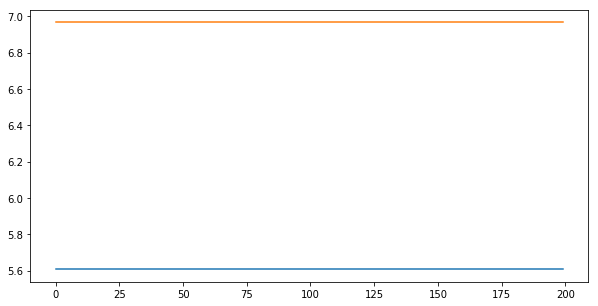

In [16]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

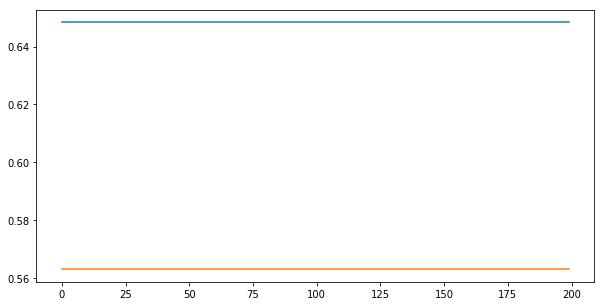

In [17]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.584070796460177
Confusion matrix, without normalization
[[  0  94]
 [  0 132]]


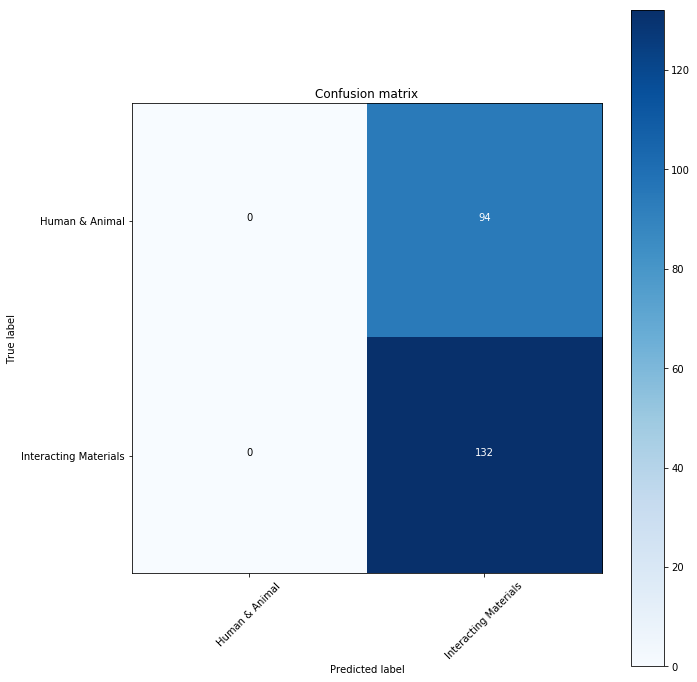

In [18]:
pred = anim.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

# All Data

In [22]:
all_df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        fld=range(2,6), 
                        blocksize=blocksize, 
                        overlap=overlap)

In [23]:
X = all_df.drop(['l_target', 'h_target'], axis=1)
y = all_df['l_target']

0.623402379903041
Confusion matrix, without normalization
[[   0 1709]
 [   0 2829]]


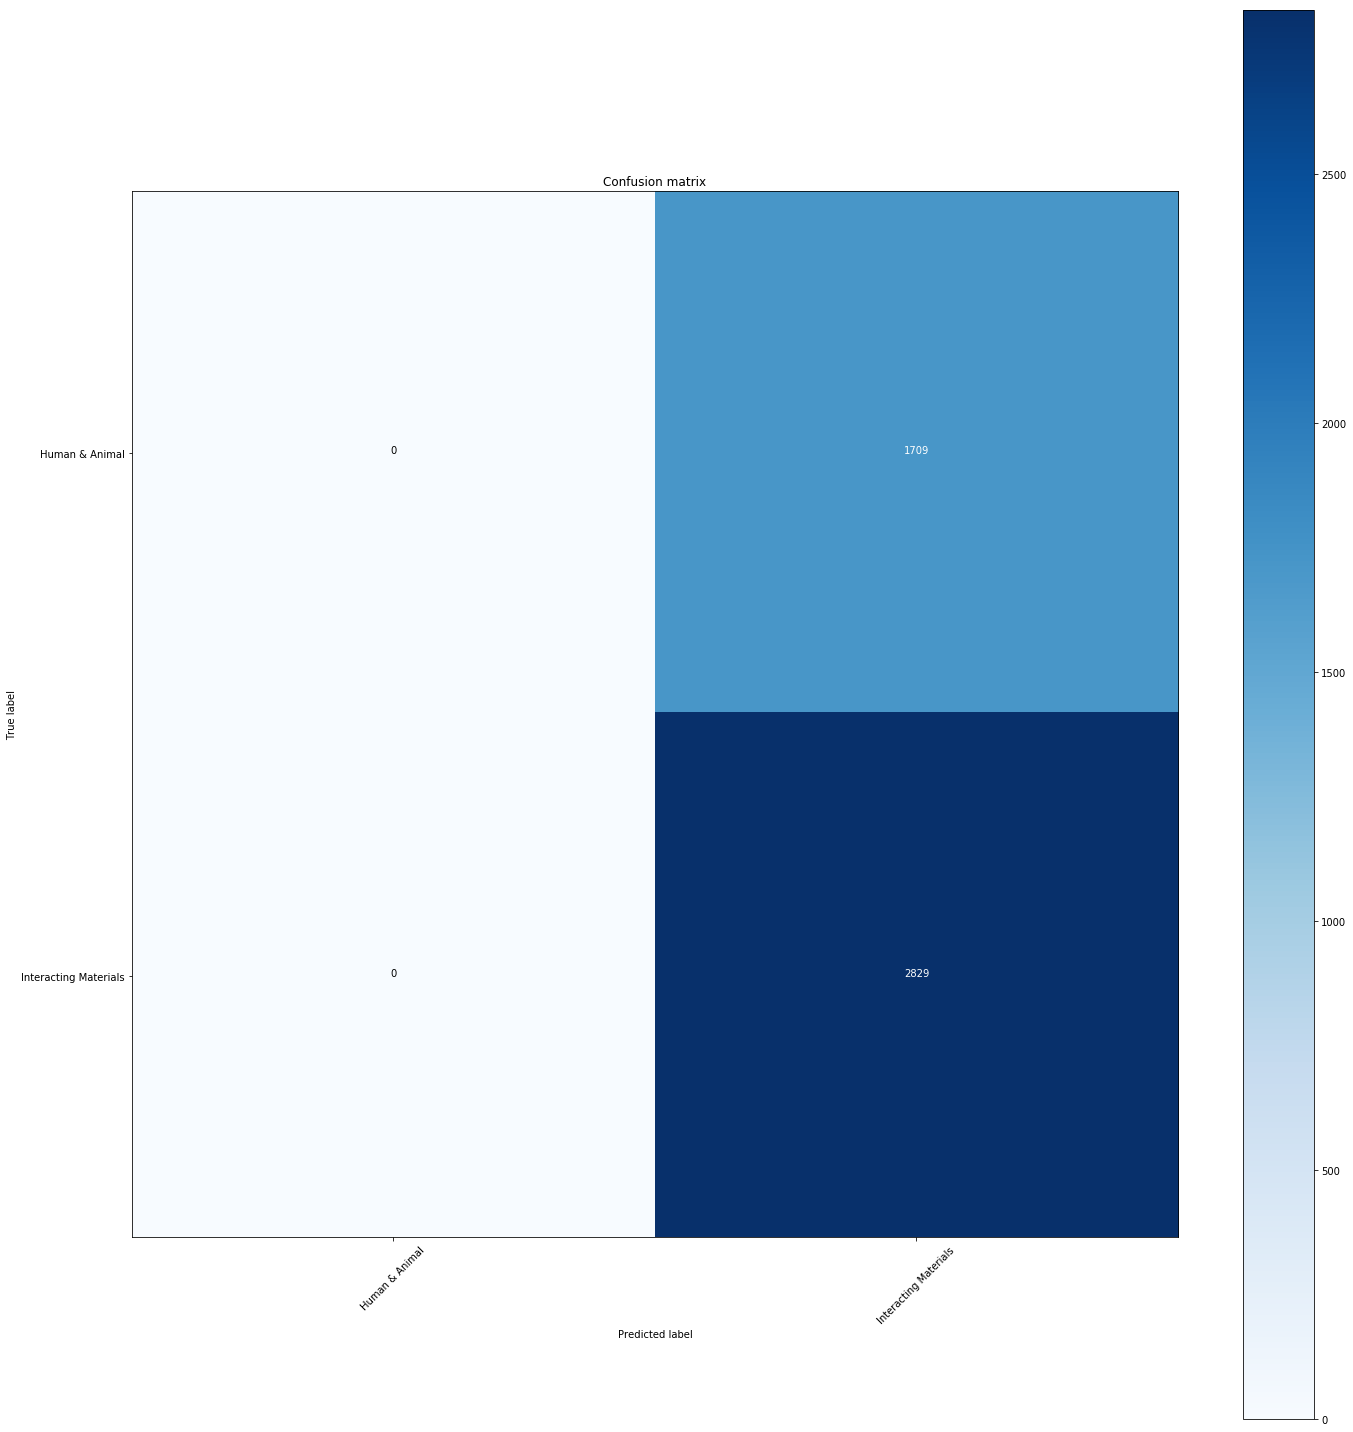

In [24]:
pred = anim.predict(X)
print(metrics.accuracy_score(y, pred))
cm = metrics.confusion_matrix(y, pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, h_classes)
plt.show()